# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Откроем файл с данными и изучим общую информацию


Импортируем библиотеки необходимые в работе.

In [ ]:
import pandas as pd

from pymystem3 import Mystem
m = Mystem()

from nltk.stem import SnowballStemmer
russian_stemmer = SnowballStemmer('russian')

import seaborn

Откроем файл с данными.
Путь к файлу: `/datasets/data.csv`

In [ ]:
data = pd.read_csv('/datasets/data.csv')

Теперь рассмотрим датасет:

In [ ]:
display(data)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем
21521,0,343937.404131,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999.806512,сделка с автомобилем
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля


Рассмотрим общую информацию о таблице:

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


**Вывод**

Из выборки мы видим, что датасет имеет следующие явные проблемы:
- столбец `'days_employed'` Трудовой стаж имеет отрицательные значения;
- столбцы `'days_employed'` Трудовой стаж и `'total_income'` Ежемесячный доход имеют пропуски;
- тип данных столбцов `'days_employed'` Трудовой стаж и `'total_income'` Ежемесячный доход лучше перевести в целочисленный; 
- столбец `'education'` Образоание имеет разный регистр;
- в столбце `'purpose'` Цель кредита одинаковые категории сформулированны по разному, нужно привечти к единообразию.

## Шаг 2. Предобработка данных
Теперь обработаем выявленные ошибки.

### Обработка пропусков
Обработаем пропуски в столбцах `'days_employed'` Трудовой стаж и `'total_income'` Ежемесячный доход. Для этого найдем пропущенные значения и посмотрим кому они соотвествуют. 

In [ ]:
display(data[data['days_employed'].isna() == True].head(10))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
65,0,NaN,21,среднее,1,Не женат / не замужем,4,M,компаньон,0,NaN,операции с коммерческой недвижимостью
67,0,NaN,52,высшее,0,женат / замужем,0,F,пенсионер,0,NaN,покупка жилья для семьи
72,1,NaN,32,высшее,0,женат / замужем,0,M,госслужащий,0,NaN,операции с коммерческой недвижимостью
82,2,NaN,50,высшее,0,женат / замужем,0,F,сотрудник,0,NaN,жилье
83,0,NaN,52,среднее,1,женат / замужем,0,M,сотрудник,0,NaN,жилье


Очевидно, что пропуск в графе Трудовой стаж соответствует также и пропуску в графе Ежемесячный доход. Похоже, что эти пропуски не случайны и у банка просто нет сведений о Стаже и Доходе клиента. Возможно клиент не работает или работает не официально.
А раз официальных сведений нет, то их можно принять за 0. 

Заменим пропуски на нули.

In [ ]:
data = data.fillna(0)
display(data.head(10))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


**Вывод**

Мы заменили пропуски нулями, так как выяснили, что пропуски не случайны, а являются следствием отсуствия данных о клиенте.
Так как банк обычно интересцют официальные данные для оценки платежеспособности клиента, то будем считать их нулевыми.

### Замена типа данных

Тип данных у столбцов `'days_employed'` Трудовой стаж и `'total_income'` Ежемесячный доход имеет тип данных `float`, но для этих данных вполне можно использовать и `int`. Так как мало кого интересует половина рабочего дня и копейки в дооде. При этом значения будут намного легче читаться.
Поэтому переведем типы данных для столбцов `'days_employed'` и `'total_income'` с `float` на `int`.

In [ ]:
data['days_employed'] = data['days_employed'].astype('int')
data['total_income'] = data['total_income'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       21525 non-null int64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null int64
purpose             21525 non-null object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


По информации о таблице видно, что столбцы сменили тип данных.
Посмотрим, как это выглядит в таблице.

In [ ]:
display(data.head(10))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,-4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,-5623,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,-4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу
5,0,-926,27,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья
6,0,-2879,43,высшее,0,женат / замужем,0,F,компаньон,0,240525,операции с жильем
7,0,-152,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823,образование
8,2,-6929,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856,на проведение свадьбы
9,0,-2188,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425,покупка жилья для семьи


**Вывод**

Изменили теп данных для столбцов `'days_employed'` и `'total_income'` с `float` на `int`. Столбцы стали легче читаться.

### Артефакты

Помимо пропусков столбец `days_employed` содержит еще и артефакт - несвойственные значения. Это отрицательны значения дней трудового стажа, но количество дней не может быть отрицательным.
Кроме того, те данные, что не отрицательны имеют слишком большую величину - около 400 тысяч дней - это больше 900 лет трудового стажа, что невозможно.

In [ ]:
data.sort_values(by = 'days_employed', ascending = False).head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
6954,0,401755,56,среднее,1,вдовец / вдова,2,F,пенсионер,0,176278,ремонт жилью
10006,0,401715,69,высшее,0,Не женат / не замужем,4,F,пенсионер,0,57390,получение образования
7664,1,401675,61,среднее,1,женат / замужем,0,F,пенсионер,0,126214,операции с жильем
2156,0,401674,60,среднее,1,женат / замужем,0,M,пенсионер,0,325395,автомобили
7794,0,401663,61,среднее,1,гражданский брак,1,F,пенсионер,0,48286,свадьба
4697,0,401635,56,среднее,1,женат / замужем,0,F,пенсионер,0,48242,покупка недвижимости
13420,0,401619,63,Среднее,1,гражданский брак,1,F,пенсионер,0,51449,сыграть свадьбу
17823,0,401614,59,среднее,1,женат / замужем,0,F,пенсионер,0,152769,покупка жилья для сдачи
10991,0,401591,56,среднее,1,в разводе,3,F,пенсионер,0,39513,получение дополнительного образования
8369,0,401590,58,среднее,1,женат / замужем,0,F,пенсионер,0,175306,образование


Можно предположить, что тут количество указано не в дня, а в часах.
Тогда разделим аномальные значения на 24 часа, чтобы получить дни.

In [ ]:
for i in range(len(data['days_employed'])):
    if data.loc[i, 'days_employed'] > 0:
        data.loc[i, 'days_employed'] = data.loc[i, 'days_employed'] / 24
display(data.head())

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.00,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,-4024.00,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,-5623.00,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,-4124.00,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,14177.75,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу


Теперь проверим значения.

In [ ]:
data.sort_values(by = 'days_employed', ascending = False).head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
6954,0,16739.791667,56,среднее,1,вдовец / вдова,2,F,пенсионер,0,176278,ремонт жилью
10006,0,16738.125000,69,высшее,0,Не женат / не замужем,4,F,пенсионер,0,57390,получение образования
7664,1,16736.458333,61,среднее,1,женат / замужем,0,F,пенсионер,0,126214,операции с жильем
2156,0,16736.416667,60,среднее,1,женат / замужем,0,M,пенсионер,0,325395,автомобили
7794,0,16735.958333,61,среднее,1,гражданский брак,1,F,пенсионер,0,48286,свадьба
4697,0,16734.791667,56,среднее,1,женат / замужем,0,F,пенсионер,0,48242,покупка недвижимости
13420,0,16734.125000,63,Среднее,1,гражданский брак,1,F,пенсионер,0,51449,сыграть свадьбу
17823,0,16733.916667,59,среднее,1,женат / замужем,0,F,пенсионер,0,152769,покупка жилья для сдачи
10991,0,16732.958333,56,среднее,1,в разводе,3,F,пенсионер,0,39513,получение дополнительного образования
8369,0,16732.916667,58,среднее,1,женат / замужем,0,F,пенсионер,0,175306,образование


Получились максимальные значения около 18 тысяч дней, что соответствует 50 годам стажа.
Так как большинство клиентов имеющих такие аномальные значения пенсионеры, то это вполне вероятно.

Теперь разберемся отрицательными значениями.
Так как данные не вызывают вопросов в плане количество, то можно предположить, что минус это просто тире, которое набирали при вводе данных, тогда переведем отрицательные значения столбца `days_employed` в положительные.

In [ ]:
data['days_employed'] = data['days_employed'].abs()
display(data.head(10))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.00,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024.00,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623.00,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,4124.00,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,14177.75,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу
5,0,926.00,27,высшее,0,гражданский брак,1,M,компаньон,0,255763,покупка жилья
6,0,2879.00,43,высшее,0,женат / замужем,0,F,компаньон,0,240525,операции с жильем
7,0,152.00,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823,образование
8,2,6929.00,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856,на проведение свадьбы
9,0,2188.00,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425,покупка жилья для семьи


Теперь оценим на наличие Артефактов другие столбцы.

Столбец Количество детей.

In [ ]:
data['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

Вот и снова артефакты.
Вопросы вызывают 47 клиентов с количеством детей -1 и 76 клиентов с количеством детей = 20.
Отрицательного значения детей быть не может, а значит в данные закралась ошибка. Как и в прошлый раз могу предположить, что это всего лишь тире, которое допустили при вводе.
Поэтому все значения с количеством детей -1 мы примем за 1.

In [ ]:
data.loc[data.loc[:, 'children'] == -1,'children'] = 1
data['children'].value_counts()

0     14149
1      4865
2      2055
3       330
20       76
4        41
5         9
Name: children, dtype: int64

Теперь нужно решить, что делать с теми, кому записано 20 детей.
Учитывая, что в данных нет людей с 6, 7 ... 19 детьми, то цифра 20 точно ошибочная.
Я предлагаю причислить эти людей к числу клиентов с 2 детьми, посчитав, что 0 в данном случае проставлен по ошибке.

In [ ]:
data.loc[data.loc[:, 'children'] == 20, 'children'] = 2
data['children'].value_counts()

0    14149
1     4865
2     2131
3      330
4       41
5        9
Name: children, dtype: int64

Теперь рассмотрим столбец Пол.
В нем мы обнаружили не смойственное значение, скорее всего это отсутствие данных о поле клиента.

In [ ]:
data['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

In [ ]:
display(data[data['gender'] == 'XNA'])


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,2358.0,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905,покупка недвижимости


Так как это значение не помешает нашему исследованию, мы можем не трогать его или перевести в более понятный для себя вид, например, заменить на '-'.

In [ ]:
data.loc[data.loc[:, 'gender'] == 'XNA', 'gender'] = '-'
data['gender'].value_counts()

F    14236
M     7288
-        1
Name: gender, dtype: int64

**Вывод**

Артефакты устранены, все данные привели в порядок.

### Обработка дубликатов

Визуально оценивая таблицу мы обнаружили, что многие данные имеют разный регистр, а разный регистр априори пораждает дубликаты.
Проверим каждый категориальный столбец на дубликаты.

Столбец образование:

In [ ]:
print(data['education'].value_counts())

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64


Дубликаты на лицо.
Приведем все категории к нижнему регистру.

In [ ]:
data['education'] = data['education'].str.lower()
print(data['education'].value_counts())

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64


Теперь все как нужно!

Столбец семейное положение:

In [ ]:
print(data['family_status'].value_counts())

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64


Хорошо бы поменять регистр у категории "Не женат / не замужем".

In [ ]:
data['family_status'] = data['family_status'].str.lower()
print(data['family_status'].value_counts())

женат / замужем          12380
гражданский брак          4177
не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64


Вот теперь все как нужно.

Столбец Тип данных:

In [ ]:
print(data['income_type'].value_counts())

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
студент                1
в декрете              1
Name: income_type, dtype: int64


Так же без нареканий.

И наконец столбец Цель получения кредита:

In [ ]:
print(data['purpose'].value_counts())

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
операции с жильем                         653
покупка жилья для сдачи                   653
операции с коммерческой недвижимостью     651
покупка жилья                             647
жилье                                     647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      624
строительство недвижимости                620
покупка своего жилья                      620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

Тут дубликаты особенные, не явные, но смысловые.
Для них воспользуемся леммизацией в следующем шаге.

А сейчас проверим наличие полных дубликатов в таблице.

In [ ]:
data.duplicated().sum()

71

Метод `duplicated()` выявил наличие 71 полный дубликат.
С одной стороны совпадение трудового стажа, наличия детей, семейного статуса и дохода вплоть до рубля очень маловероятно.
С другой стороны данные обезличены, у нас нет уникальных идентификаторов клиентов, а значит и уверенности, что это одни и те же люди.

Рассмотрим эти дубликаты ближе.

In [ ]:
display(data[data.duplicated() == True])

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
2849,0,0.0,41,среднее,1,женат / замужем,0,F,сотрудник,0,0,покупка жилья для семьи
3290,0,0.0,58,среднее,1,гражданский брак,1,F,пенсионер,0,0,сыграть свадьбу
4182,1,0.0,34,высшее,0,гражданский брак,1,F,сотрудник,0,0,свадьба
4851,0,0.0,60,среднее,1,гражданский брак,1,F,пенсионер,0,0,свадьба
5557,0,0.0,58,среднее,1,гражданский брак,1,F,пенсионер,0,0,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
20702,0,0.0,64,среднее,1,женат / замужем,0,F,пенсионер,0,0,дополнительное образование
21032,0,0.0,60,среднее,1,женат / замужем,0,F,пенсионер,0,0,заняться образованием
21132,0,0.0,47,среднее,1,женат / замужем,0,F,сотрудник,0,0,ремонт жилью
21281,1,0.0,30,высшее,0,женат / замужем,0,F,сотрудник,0,0,покупка коммерческой недвижимости


Я заметила, что у всех дубликатов отсутствуют значения в столбце `days_employed` Стаж и  `total_income` Доход. 
Проверим точно ли это так.

In [ ]:
display(data[(data.duplicated() == True) & (data['days_employed'] != 0)])
display(data[(data.duplicated() == True) & (data['total_income'] != 0)])

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose


Да, действительно, все дубликаты не имеют самых многовариативных параметров - Стажа и Дохода.
Остальные данные, такие как пол, возраст, семейное положение, с большой долей вероятности могут просто совпасть.
Поэтому, я считаю, что удалять такие дубликаты не стоит.

**Вывод**

Избавились от причин, которые могут вызывать дубликаты.
Рассмотрели наличие дубликатов, обнаружили 71 дубликат.
Но при более близком рассмотрении сделали вывод, что при отсутствии индивидуальной идентификации клиента подобные данные могут просто совпасть. Поэтому решено не удалять дубликаты.

### Лемматизация

Обработаем столбец `purpose`, он содержит Цель получения кредита. У многих цели схожие, а записаны они по разному. То есть это не явные дубликаты, а смысловые. Для того, чтобы привести эти данные к единым значениям, нужно выделить леммы.

In [ ]:
lemmas = []

for i in data['purpose'].unique():
    lemmas = ' '.join(m.lemmatize(i))
    lemmas = lemmas.split()
    print(lemmas)

['покупка', 'жилье']
['приобретение', 'автомобиль']
['дополнительный', 'образование']
['сыграть', 'свадьба']
['операция', 'с', 'жилье']
['образование']
['на', 'проведение', 'свадьба']
['покупка', 'жилье', 'для', 'семья']
['покупка', 'недвижимость']
['покупка', 'коммерческий', 'недвижимость']
['покупка', 'жилой', 'недвижимость']
['строительство', 'собственный', 'недвижимость']
['недвижимость']
['строительство', 'недвижимость']
['на', 'покупка', 'подержать', 'автомобиль']
['на', 'покупка', 'свой', 'автомобиль']
['операция', 'с', 'коммерческий', 'недвижимость']
['строительство', 'жилой', 'недвижимость']
['жилье']
['операция', 'со', 'свой', 'недвижимость']
['автомобиль']
['заниматься', 'образование']
['сделка', 'с', 'подержанный', 'автомобиль']
['получение', 'образование']
['автомобиль']
['свадьба']
['получение', 'дополнительный', 'образование']
['покупка', 'свой', 'жилье']
['операция', 'с', 'недвижимость']
['получение', 'высокий', 'образование']
['свой', 'автомобиль']
['сделка', 'с', 'авт

Из выведеных значений понятно, что есть несколько основных направлений для займа:
- недвижимость
- автомобиль
- образование
- свадьба

При этом недвижимость может быть:
- жилая
- коммерческая

Займ на недвижимость с целью:
- приобретения
- строительства
- ремонта
- иных операций

Исходя из этого привидем данные к единообразию.

Возьмем все интересующие нас слова и найдем их стемпы.

In [ ]:
kategor = ['жилье', 'недвижимость', 'автомобиль', 'образование', 'свадьба']
stemmping = []
for i in kategor:
    stemmping.append(russian_stemmer.stem(i))
print(stemmping)

['жил', 'недвижим', 'автомобил', 'образован', 'свадьб']


Теперь с помощью этих стемпов отнесем все варианты целей к единообразным значениям.

In [ ]:
for i in range(len(data['purpose'])):
    
    if 'жил' in data.loc[i, 'purpose']:
        data.loc[i, 'purpose'] = 'операции с недвижимостью'
        
    if 'недвижим' in data.loc[i, 'purpose']:
        data.loc[i, 'purpose'] = 'операции с недвижимостью'

    if 'автомобил' in data.loc[i, 'purpose']:
        data.loc[i, 'purpose'] = 'приобретение автомобиля'
            
    if 'свадьб' in data.loc[i, 'purpose']:
        data.loc[i, 'purpose'] = 'проведение свадьбы'   
    
    if 'образован' in data.loc[i, 'purpose']:
        data.loc[i, 'purpose'] = 'получение образования' 
            
print(data['purpose'].value_counts())
            

операции с недвижимостью    10840
приобретение автомобиля      4315
получение образования        4022
проведение свадьбы           2348
Name: purpose, dtype: int64


**Вывод**

При помощи лемматизации и стемпинга приведи цели получения займа к единообразию и ясности. Теперь с данными удобно работать.

### Категоризация данных

Для ответов на вопросы нам понадобится разделить наши данные на категории.
Я предлагаю:
- для возраста выделить категории - молодой (18 - 35 лет), средний (35 - 65 лет) и пенсионный (65+ лет)

Для этого создадим новый столбец `kat_years`, который будет содержать категории возраста.

In [ ]:
for i in range(len(data['purpose'])):
    if data.loc[i, 'dob_years'] >= 18 and data.loc[i, 'dob_years'] <= 35 :
        data.loc[i, 'kat_years'] = 'молодой'
    if data.loc[i, 'dob_years'] > 35  and data.loc[i, 'dob_years'] < 65 :
        data.loc[i, 'kat_years'] = 'средний'
    if data.loc[i, 'dob_years'] >= 65:
        data.loc[i, 'kat_years'] = 'пенсионный'
        

print(data['kat_years'].value_counts())

средний       13931
молодой        6594
пенсионный      899
Name: kat_years, dtype: int64


**Вывод**
Выделили категории для более наглядного изучения групп клиентов по возрасту и заработку.

Теперь данные готовы для того, чтобы ответить на поставленные вопросы и проверить гипотезы.

## Шаг 3. Ответим на вопросы

Теперь ответим на основные вопросы исследования.

- **Есть ли зависимость между наличием детей и возвратом кредита в срок?**

Для того, чтобы ответить на этот вопрос соберем в отдельный массив `graf` количество должников для каждой группы клиентов, разделяя их по количеству детей.
Мы помним, что в датасете максимальное количество детей у клиентов было 5, на графике отложим его по оси Х.

          debt
children      
0         1063
1          445
2          202
3           27
4            4
5            0


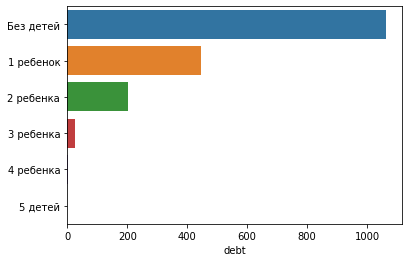

In [ ]:
graf = data.groupby('children').agg({'debt': 'sum'})

print(graf)

seaborn.barplot(x=graf['debt'], y=['Без детей', '1 ребенок', '2 ребенка', '3 ребенка','4 ребенка','5 детей'])

Из результатов видно, что чем больше у клиента детей, тем отвественнее он подходит к выплате кредита.
Подавляющее большентсво задолженностей приходится на бездетных клиентов.

Но возможно это связано с тем, что количество бездетных клиентов намного больше, чем других?
В таком случае правильнее будет посчитать среднее, а не сумму задолженностей на группу.

              debt
children          
0         0.075129
1         0.091470
2         0.094791
3         0.081818
4         0.097561
5         0.000000


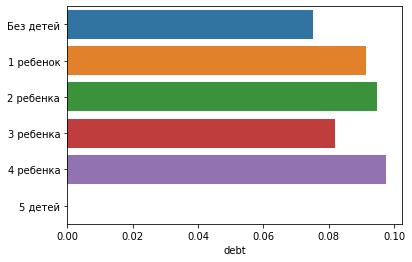

In [ ]:
graf = data.groupby('children').agg({'debt': 'mean'})

print(graf)

seaborn.barplot(x=graf['debt'], y=['Без детей', '1 ребенок', '2 ребенка', '3 ребенка','4 ребенка','5 детей'])

Данные различаются не сильно, хотя клиенты не имеющие детей имеют наименьшее число просрочек по кредитам.
Попробуем разделить клиентов просто по наличию и отсуствию детей. 

              debt
children          
0         0.075129
1         0.091470
2         0.094791
3         0.081818
4         0.097561
5         0.000000


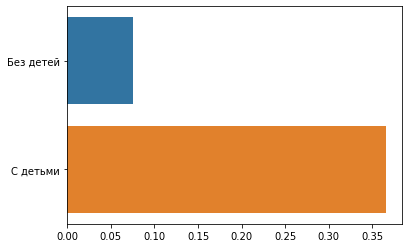

In [ ]:
graf = data.groupby('children').agg({'debt': 'mean'})

grafsum = (sum(graf['debt']) - graf.loc[0, 'debt']).mean()
print(graf)

seaborn.barplot(x=[graf.loc[0, 'debt'], grafsum], y=['Без детей', 'С детьми'])

Теперь разница очевидна.

**Вывод**

Из среднего значения на каждую группу клиентов видно, что распределение задолженностей примерно одинаково. 
Клиенты с 4 детьми имеют задолженности чуть чаще остальных.
В целом кдиенты не имеющие детей, согласно графику, выглядят наиболее дисциплинированными.
Я думаю, что эту гипотезу можно считать не до конца подтвержденной, можно разделить клиентов на имеющих и не имеющих детей, и неимеющие будут считаться более платежеспособными, а клиенты имеющие детей - менее.

- **Есть ли зависимость между семейным положением и возвратом кредита в срок?**

Для того, чтобы ответить на этот вопрос соберем в отдельный массив `graf` количество должников для каждой группы клиентов, разделяя их по индификатору семейного положения.


                       debt
family_status              
в разводе                85
вдовец / вдова           63
гражданский брак        388
женат / замужем         931
не женат / не замужем   274


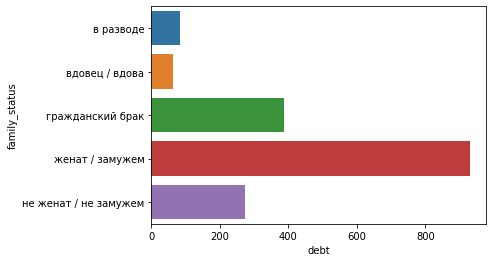

In [ ]:
graf = data.groupby('family_status').agg({'debt': 'sum'})

print(graf)
    
seaborn.barplot(x=graf['debt'], y=graf.index)

А теперь посмотрим, как изменятся показатели, если мы учтем численность каждой группы и посчитаем среднее.

                           debt
family_status                  
в разводе              0.071130
вдовец / вдова         0.065625
гражданский брак       0.092890
женат / замужем        0.075202
не женат / не замужем  0.097405


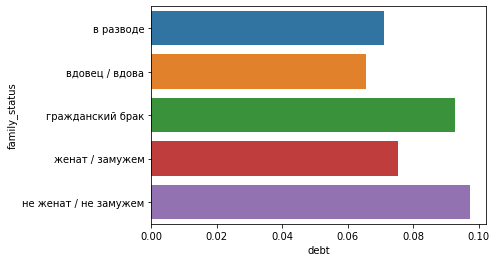

In [ ]:
graf = data.groupby('family_status').agg({'debt': 'mean'})

print(graf)
    
seaborn.barplot(x=graf['debt'], y=graf.index)

**Вывод**

С учетом численности, клиенты не женатые клиенты и клиенты находящиеся в гражданском браке имеют наибольшее количество задолженностей.
Тут, я считая, гипотезу можно считать подтвержденной.
Зависимость между семейным положением и наличием задолженности действительно очевидна.

- **Есть ли зависимость между уровнем дохода и возвратом кредита в срок?**

Для того, чтобы ответить на этот вопрос соберем в отдельный массив graf количество должников для каждой группы клиентов, разделяя их по возрастной категории.

Обозначения:

- молодой - от 18 до 35 лет
- средний - от 35 до 65 лет
- пенсионный - старше 65 лет.

Так как мы уже выяснили, что данные без учета сичленности группы не показателны, то будем сразу считать среднее.

                debt
kat_years           
молодой     0.105854
пенсионный  0.054505
средний     0.070777


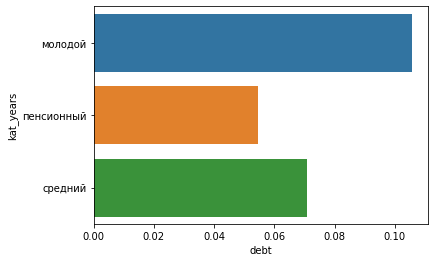

In [ ]:
graf = data.groupby('kat_years').agg({'debt': 'mean'})

print(graf)    

seaborn.barplot(x=graf['debt'], y=graf.index)

**Вывод**

Согласно графику, должниками чаще всего является молодежь.
А самые обязательными оказываются пенсионеры.
Гипотезу точно можно считать подтвержденной, так как зависимость очевидна.

- **Как разные цели кредита влияют на его возврат в срок?**

Для того, чтобы ответить на этот вопрос соберем в отдельный массив graf количество должников для каждой группы клиентов, разделяя их по категориям цели кредитования.


Так как мы уже выяснили, что данные без учета членности группы не показателны, то будем сразу считать среднее.

                              debt
purpose                           
операции с недвижимостью  0.072140
получение образования     0.091994
приобретение автомобиля   0.093395
проведение свадьбы        0.079216


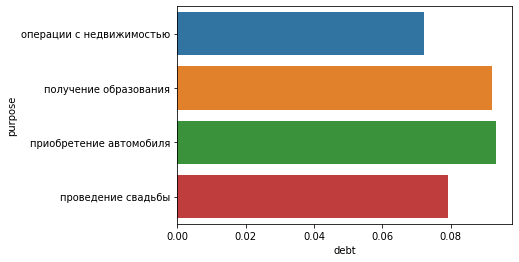

In [ ]:
graf = data.groupby('purpose').agg({'debt': 'mean'})

print(graf)

seaborn.barplot(x=graf['debt'], y=graf.index)

**Вывод**

Чаще всего клиенты задерживают платежи по кредитам на автомобиль и образование, а за недвижимость платят исправнее всего. 
Из этого мы можем сделать вывод, что зависимость между целью кредита и наличием задолженности действительно существует.

## Шаг 4. Общий вывод

Проведя исследование, мы выяснили, что 3 из 4 гипотез подтвердились, а 1 подтвердилась частично.
Наличие задолженности, действительно зависит от возраста, семейного положения и цели кредитования.
Так молодые клиенты не женатые клиенты или кленты состоящие в гражданском браке, взявшие кредит на автомобиль или образование чаще имеют задолженности, чем остальные.
Количество же детей не сильно влияет на платежеспособность клиента, тут правильнее выделить категорию клиентов с детьми и без.